In [32]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [33]:
def fib(n):
    a,b = 0., 1.
    for _ in range(n):
        a,b = a+b,a
    return a

In [108]:
%%cython

cdef float fib(int n):
    cdef int i
    cdef double a=0.0, b=1.0
    for i in range(n):
        a, b = a+b,a
    return a

from cpython cimport array as c_array
from array import array

ctypedef c_array.array c_arr
cdef int E00=0
cdef int E01=1
cdef int E10=2
cdef int E11=3


cdef c_arr mat_2_prod(c_arr m1,c_arr m2):
    cdef c_arr m3 = array('f',[0.,0.,0.,0.])
    m3[E00] = m1[E00]*m2[E00] + m1[E01]*m2[E10]
    m3[E01] = m1[E00]*m2[E01] + m1[E01]*m2[E11]
    m3[E10] = m1[E10]*m2[E00] + m1[E11]*m2[E10]
    m3[E11] = m1[E10]*m2[E01] + m1[E11]*m2[E11]
    return m3

cdef float fib_fast(unsigned int n):
    bins = [y=='1' for y in bin(n)[:1:-1]]
    cdef c_arr x = array('f', [1.,0.,0.,1.])
    cdef c_arr p = array('f',[1.,1.,1.,0.])
    cdef unsigned int N = 0x1
    cdef char div
    while N <= n:
        div = n & N
        if div:
            x = mat_2_prod(x,p)
        p = mat_2_prod(p,p)
        N <<= 1
    return x[E10]

def cfib_fast(n):
    return fib_fast(n)
def cfib(n):
    return fib(n)

In [109]:
n = 8
print(cfib(n))
print(cfib_fast(n))

21.0
21.0


In [110]:
fib_mat = [[1.,1.],[1.,0.]]

def mat_2_prod(m1, m2):
    m3 = [[0.,0.],[0.,0.]]
    m3[0][0] = m1[0][0]*m2[0][0] + m1[0][1]*m2[1][0]
    m3[0][1] = m1[0][0]*m2[0][1] + m1[0][1]*m2[1][1]
    m3[1][0] = m1[1][0]*m2[0][0] + m1[1][1]*m2[1][0]
    m3[1][1] = m1[1][0]*m2[0][0] + m1[0][1]*m2[1][0]
    return m3


def fib_fast(n):
    bins = [x=='1' for x in bin(n)[:1:-1]]
    x = [[1.,0.],[0.,1.]]
    p = fib_mat
    for i, val in enumerate(bins):
        if val:
            x = mat_2_prod(x,p)
        p = mat_2_prod(p,p)
    return x[1][0]

In [125]:
import time
data = {fib  : [],
        cfib : [],
        fib_fast : [],
        cfib_fast : []
        }
ns = np.logspace(1,7, num=10, dtype=np.int64)[::-1]
N = 20
for n in ns:
    for func,times in data.items():
        t_start = time.time()
        for _ in range(N): 
            func(n)
        t_end = time.time()
        times.append(t_end-t_start)


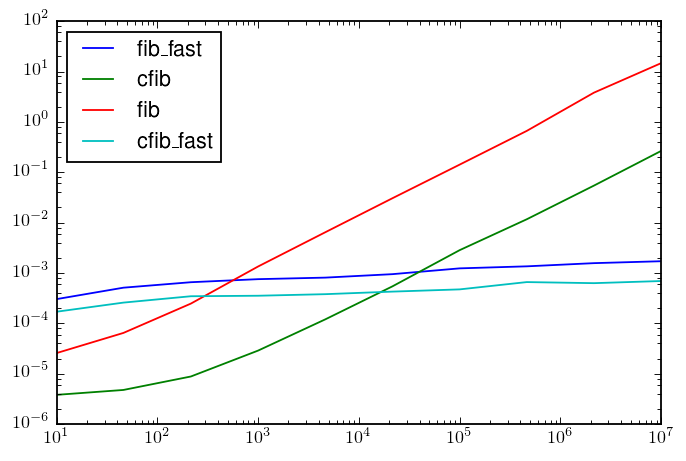

In [126]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['savefig.dpi']=130
plt.xscale('log')
plt.yscale('log')
for func, times in data.items():
    plt.plot(ns, times, label=func.__name__.replace('_',r'\_'))
plt.legend(loc='best')
plt.show()